# Author: Midrar Adham
## Corner Reliability & project Proposal

In [6]:
import os
import sys
import random
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

**Select a set of 5-10 images. Convert them to grayscale and show them**
---

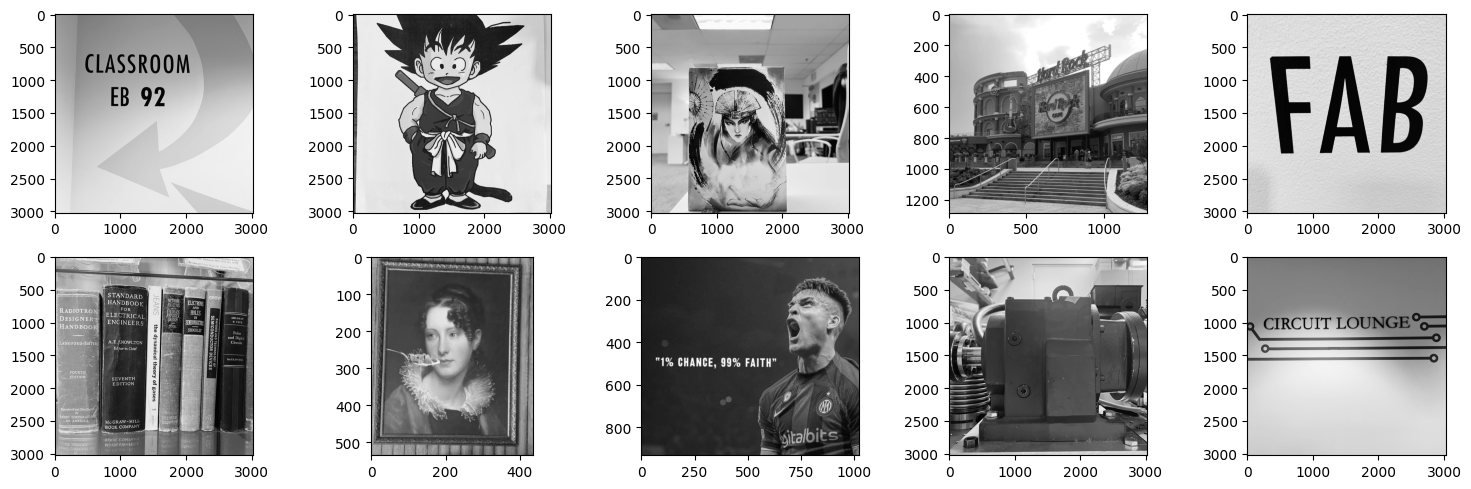

In [7]:
dir = '../../sample_data/hw6_images_2/'
images = os.listdir(dir)

_, ax = plt.subplots(2, 5, figsize=(15, 5))
ax = ax.flatten()
for img, ax in zip(images, ax):
    img = cv.imread(dir + img, cv.IMREAD_GRAYSCALE)
    ax.imshow(img, cmap='gray')

plt.tight_layout()



**Develop a means of transforming images using a perspective transform such that if the image were taken 5 meters away, the transformed image is taken with an equivalent of a camera location that has changed position according to a 3D gaussian distribution with a standard deviation of 1 meter and has changed its orientation by rotation along a random axis by an angle randomly chosen from a uniform distribution ranging from 0 to 10 degrees. Also randomly alter the scale of the image intensity with a uniform distribution of 0.95 to 1.05 and the brightness by -0.10 to 0.10. Show a selection of 10 examples of randomly selected images before and after the transform.**
---

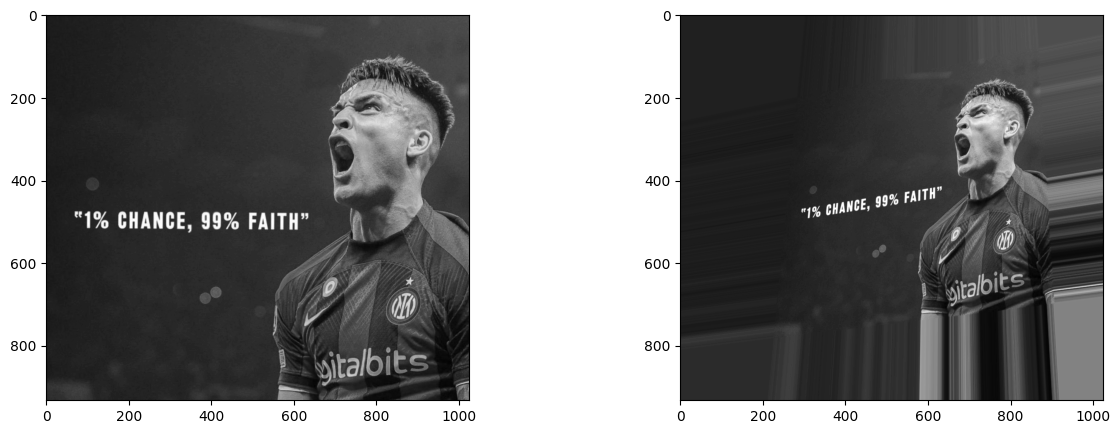

In [14]:
def scale_img (img):
    pass

def rotate_images(img, directory):
    
    image = cv.imread(directory + img, cv.IMREAD_GRAYSCALE)
    # image = image[499:1000, 499:1000]
    std_dev = 1
    k = 350
    pos_1 = np.random.randint(0, k, 2)
    pos_2 = np.random.randint(0, k, 2)
    pos_3 = np.random.randint(0, k, 2)
    pos_4 = np.random.randint(0, k, 2)
    angle = random.randint(-10, 10)

    # Initialize the rotation matrix
    rotation_matrix = cv.getRotationMatrix2D(center = (image.shape[1] / 2, image.shape[0] / 2), angle=angle, scale=1)
    # Add a third row for the rotation matrix so considering homogensous coordinates
    rotation_matrix = np.vstack([rotation_matrix, [0, 0, 1]])
    # Apply rotation to image
    rotated_image = cv.warpPerspective(image, rotation_matrix, (image.shape[1], image.shape[0]))
    # Define the image corners after rotation (Not really doing what it's supposed to do, change later if there is time)
    corner_1 = np.float32([0,0])
    corner_2 = np.float32([0, rotated_image.shape[1]-1])
    corner_3 = np.float32([rotated_image.shape[0]-1,rotated_image.shape[1]-1])
    corner_4 = np.float32([rotated_image.shape[0]-1, 0])

    # Define the source and destination points (Similar to Dr. McNames code)
    src_points = np.float32([corner_1, corner_2, corner_3, corner_4])
    dst_points = np.float32([corner_1 + pos_1, corner_2 + [pos_2[0], pos_2[1] - k], corner_3 + pos_3 - k, corner_4 + [pos_4[0] - k, pos_4[1]]])

    # Get the projective matrix
    projective_matrix = cv.getPerspectiveTransform(src_points, dst_points)
    warped_image = cv.warpPerspective(image, projective_matrix, (image.shape[1], image.shape[0]), borderMode=cv.BORDER_REPLICATE)

    brightness = np.random.randint(-50,50+1)
    cv.add(warped_image, brightness, warped_image)
    scale = 1 + np.random.uniform(-0.2,0.2)
    cv.multiply(warped_image, scale, warped_image)
    
    return image, warped_image, projective_matrix

dir = '../../sample_data/hw6_images_2/'
orig, rotated, matrix = rotate_images(img='lauti.JPG', directory=dir)
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(orig, cmap='gray')
ax[1].imshow(rotated, cmap='gray')


**Apply the Harris corner detector to both images. Indicate the 20 most prominent features on the original image. Also indicate where you would expect the 20 most prominent features to occur in the transformed image. Finally, show the 20 most prominent features detected in the transformed image. Show 10 examples of randomly selected and transformed image pairs.**
---

[481 481 481 482 482 482 483 483 483 511 511 511 512 512 512 513 513 513
 488 488 488 489 489 489 490 490 490 480 480 480 483 483 483 484 484 484
 485 485 485 481]
[629 629 629 630 630 630 631 631 631 635 635 635 636 636 636 637 637 637
 629 630 631 628 628 628 635 636 637 641 641 641 642 642 642 643 643 643
 554 554 554 555]


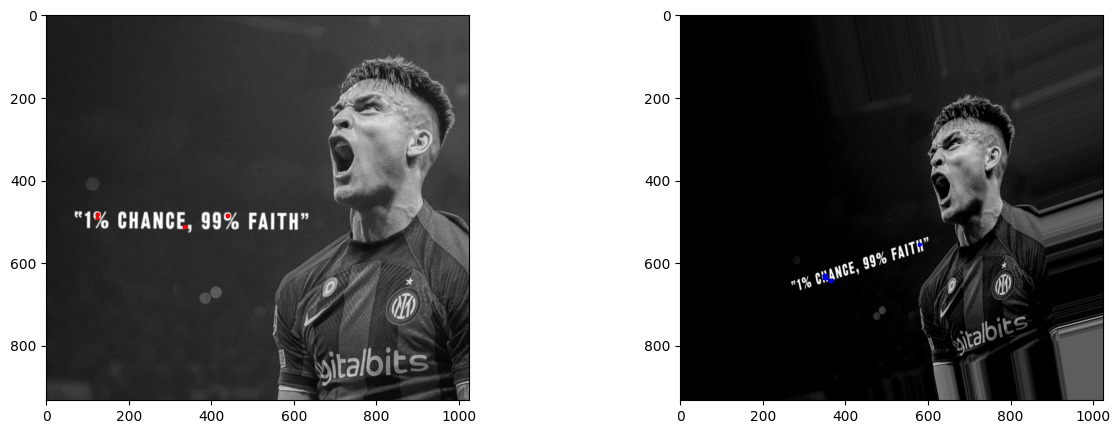

In [239]:
def harris_corner(gray):
    gray = np.float32(gray) # Why?
    dst = cv.cornerHarris(src=gray,blockSize=3,ksize=3,k=0.04) # Diff between ksize and blockSize?
    dst = cv.dilate(dst, None) # No kernel to the dilation = None.
    threshold = 0.01 * dst.max()
    mask = dst > threshold # Boolean. Values within the threshold are True, else False.
    coords = np.argwhere(mask) # 2D array. Return the indices of the none zero elements (NOT THE ELEMENTS THEMSELVES)
    detected_corners = []
    for corner in coords:
        y, x = corner # coordinates for each corner.
        corner_loc_image = dst[y,x] # Get the coords where the indices (x,y) point at in the image
        detected_corners.append(corner_loc_image) # Append the coordinates to a list so I can sort the prominent ones later.
    '''
    detected_corners list contains the highest values of elements within the image that are above the specified 
    threshold. These corners values are the response R at each pixels from the harris corner detection algorithm:
    R = det(M) - k x (trace(M))^2
    Look at the harris_corner notes.
     
    The next step is to sort these values from highest to lowest and pick the first 20 features.
    '''

    '''
    A problem lies here that the corners are very close to each other (numerically). 
    '''
    paired_corners = zip(coords, detected_corners)
    # Sorting the data based on the response (gradients). The highest values is the most prominent features.
    # The sorted() is an ascending order. Using reverse=True make the list in descending order.
    # sort the paired_corners based on the response (detected_corners)
    
    sorting = sorted(paired_corners, key=lambda x: x[1], reverse=True)
    # sorting = sorted(paired_corners, key=lambda x: x[1], reverse=True)
    # Try several number of features.
    prom_features = sorting[:40]
    # print(prom_features)
    '''
    It is easier to see things clearly if you print the prom_features. The x,y coordinates are moving correctly. However,

    
    '''
    prom_corners = np.array([corner[0] for corner in prom_features])
    # print(prom_corners)
    prom_resp = np.array([corner[1] for corner in prom_features])

    return prom_corners, prom_resp



orig, rotat, matrix = rotate_images('lauti.JPG', dir)
# orig = cv.GaussianBlur(orig, (7,7),0)
x_orig,y_orig = harris_corner(gray=orig)
x_rotat,y_rotat = harris_corner(gray=rotat)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(orig, cmap='gray')
ax[0].scatter(x_orig[:,1], x_orig[:,0], c='r', marker = 'o', s=2)
ax[1].imshow(rotat, cmap='gray')
ax[1].scatter(x_rotat[:,1], x_rotat[:,0], c='b', marker = 'o', s=2)
# plt.show()
print(x_orig[:,0])
print(x_rotat[:,0])



In [107]:
def harris_corner(img):
    gray = cv.GaussianBlur(img, (7,7),0)
    gray = np.float32(gray) # Why?
    dst = cv.cornerHarris(src=gray,blockSize=3,ksize=3,k=0.04) # Diff between ksize and blockSize?
    dst = cv.dilate(dst, None) # No kernel to the dilation = None.
    threshold = 0.01 * dst.max()
    mask = dst > threshold # Boolean. Values within the threshold are True, else False.
    coords = np.argwhere(mask) # 2D array. Return the indices of the none zero elements (NOT THE ELEMENTS THEMSELVES)
    return coords, dst

def get_prominent_features (coords, dst):
    detected_corners = []
    for corner in coords:
        y, x = corner # coordinates for each corner.
        corner_loc_image = dst[y,x] # Get the coords where the indices (x,y) point at in the image
        detected_corners.append(corner_loc_image) # Append the coordinates to a list so I can sort the prominent ones later.
    paired_corners = zip(coords, detected_corners)
    sorting = sorted(paired_corners, key=lambda x: x[1], reverse=True)
    no_resp_coords = sorting[:100]
    no_resp_coords = np.array([corner[0] for corner in no_resp_coords])
    return no_resp_coords

def get_corners_distance (orig_coords, rotated_coords):
    # return np.linalg.norm(orig_coords - rotated_coords)
    return np.sqrt((orig_coords[0] - rotated_coords[0])**2 + (orig_coords[1] - rotated_coords[1])**2)
    

def matching_corners (orig_coords, rotated_coords):
    matches = []
    for coords1 in orig_coords:
        min_distance = float('inf')
        nearest_coord = None
        for coords2 in rotated_coords:
            distance = get_corners_distance(coords1, coords2)
            if distance < min_distance:
                min_distance = distance
                nearest_coord = coords2
        matches.append((coords1, nearest_coord, min_distance))
    
    return matches

def get_accuracy (matches, threshold):
    correct_matches = [match for match in matches if match[2] < threshold]
    accuracy = len(correct_matches) / len(matches)
    return accuracy

if __name__ == '__main__':
    accuracy = []
    for i in range(1000):
        orig, rotat, matrix = rotate_images('lauti.JPG', dir)
        coords1, harris_img1 = harris_corner(orig)
        coords2, harris_img2 = harris_corner(rotat)
        
        coords1 = get_prominent_features(coords1, harris_img1)
        coords2 = get_prominent_features(coords2, harris_img2)
        
        matches = matching_corners(orig_coords=coords1, rotated_coords=coords2)
        acc = get_accuracy(matches, threshold=100)
        accuracy.append(acc* 100)
    accuracy = list(set(accuracy))
    print(accuracy)
        # fig, ax = plt.subplots(1, 2, figsize=(15, 15))
        
    # ax[0].imshow(orig, cmap='gray')
    # ax[0].scatter(coords1[:,1], coords1[:,0], c='r', marker = 'o', s=2)
    # ax[1].imshow(rotat, cmap='gray')
    # ax[1].scatter(coords2[:,1], coords2[:,0], c='r', marker = 'o', s=2)
    # ax[1].set_title(f'The accuracy of the matched points: \n{accuracy* 100}%')
    

    

[0.0, 2.0, 4.0, 6.0, 9.0, 10.0, 11.0, 12.0, 13.0, 15.0, 17.0, 18.0, 19.0, 21.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.000000000000004, 28.999999999999996, 30.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.00000000000001, 56.00000000000001, 56.99999999999999, 57.99999999999999, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 70.0, 71.0, 72.0, 73.0, 78.0, 80.0, 81.0, 82.0, 83.0, 85.0, 87.0, 90.0, 91.0, 100.0]


**For each image pair, calculate the number of matches. A match occurs when a point is detected in both images within 1 pixel. Repeat this many times to get a precise estimate of the percentage of matches.**
---

**Repeat step 3 using SIFT**
---

**Repeat step 4 for SIFT where a match is counted if a point is detected within 1 sigma, where sigma is the scale and within 1.41 of the correct scale (just like Lowe did).**
---

**Which algorithm performed best in your experiments? What are the tradeoffs between these algorithms, based on your experience?**
---

**What did you learn from this assignment?**
---

**What questions do you have for me?**
---

**What would you like to do for your project at the end of this term? Think of the project as taking as much time as two homework assignments.**
---

**What do you think you will learn from completing your project?**
---